In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('weather.csv')
df.drop('_id', axis=1, inplace=True)

In [3]:
null_pct=df.apply(pd.isnull).sum()/df.shape[0]
valid_columns=df.columns[null_pct<0.5]
valid_columns

Index(['Date', 'Rain', 'Temp Max', 'Temp Min'], dtype='object')

In [4]:
df=df[valid_columns].copy()
df.columns=df.columns.str.lower()
df=df.ffill()
df.index=pd.to_datetime(df['date'])
df['target']=df.shift(-1)['temp max']
df=df.ffill()
df.drop('date', axis=1, inplace=True)
df

,rain,temp max,temp min,target
date,,,,
1951-01-01,0.000000,24.790001,12.980000,23.580000
1951-02-01,0.000000,23.580000,10.980000,23.850000
1951-03-01,0.000000,23.850000,10.970000,24.680000
1951-04-01,0.000000,24.680000,12.020000,24.639999
1951-05-01,0.000000,24.639999,12.920000,25.379999
...,...,...,...,...
2020-10-20,0.000000,33.841103,26.213280,33.008148
2020-10-21,0.000000,33.008148,26.055851,29.939440
2020-10-22,1.858168,29.939440,25.823761,29.854029


<Axes: xlabel='date'>

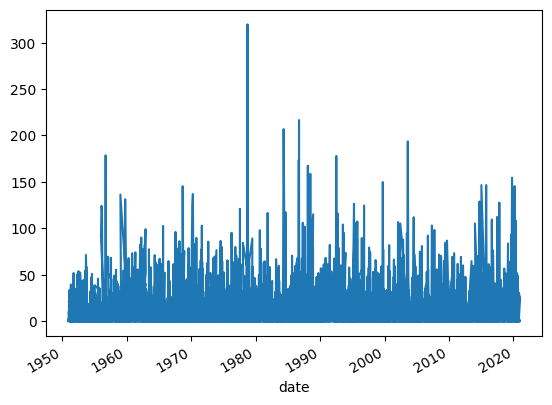

In [5]:
df['rain'].plot()

In [6]:
from sklearn.linear_model import Ridge
rr=Ridge(alpha=0.1)

In [7]:
predictors=df.columns[~df.columns.isin(['target'])]
predictors

Index(['rain', 'temp max', 'temp min'], dtype='object')

In [8]:
def backtest(df,model,predictors,start=3650,step=90):
    all_predictions=[]
    for i in range(start,df.shape[0],step):
        train=df.iloc[:i,:]
        test=df.iloc[i:i+step]
        model.fit(train[predictors],train['target'])
        preds=model.predict(test[predictors])
        preds=pd.Series(preds, index=test.index)
        combined=pd.concat([test['target'], preds], axis=1)
        combined.columns=['actual','predictions']
        combined['diff']=(combined['predictions'] - combined['actual']).abs()
        all_predictions.append(combined)
    return pd.concat(all_predictions,axis=0)

In [9]:
predictions=backtest(df,rr,predictors)
predictions['diff'].mean()

np.float64(0.8045976941713971)

In [10]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions['actual'], predictions['predictions'])

0.8045976941713971

In [11]:
def rain_diff(old,new):
    return (new - old)/ old
def compute_rolling(df,horizon,col):
    label=f"rolling_{horizon}_{col}"
    df[label]=df[col].rolling(horizon).mean()
    df[f"{label}_pct"]=rain_diff(df[label],df[col])
    return df
rolling_horizons=[3,14]
for horizon in rolling_horizons:
    for col in ['temp max', 'temp min', 'rain']:
        df=compute_rolling(df, horizon, col)

In [12]:
df=df.iloc[14:,:]
df=df.fillna(0)

In [13]:
def expand_mean(df):
    return df.expanding(1).mean()
for col in['temp max', 'temp min', 'rain']:
    df[f"month_avg`_{col}"]=df[col].groupby(df.index.month,group_keys=False).apply(expand_mean)
    df[f"day_avg_{col}"]=df[col].groupby(df.index.day_of_year,group_keys=False).apply(expand_mean)

In [ ]:
df.to_csv('weather_processed.csv')

In [15]:
predictors=df.columns[~df.columns.isin(['target'])]

In [16]:
predictions=backtest(df,rr,predictors)

In [17]:
mean_absolute_error(predictions['actual'], predictions['predictions'])

0.7708394355301925

<Axes: xlabel='diff'>

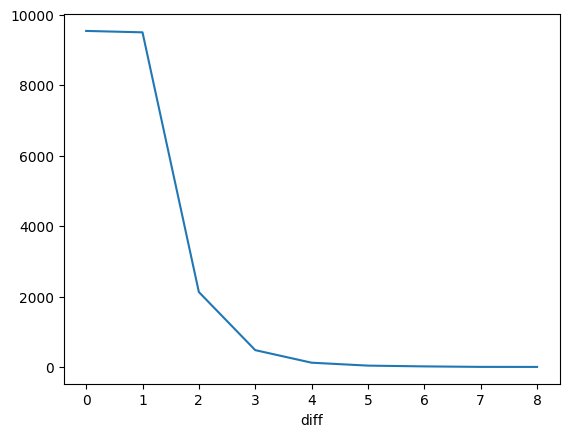

In [18]:
predictions["diff"].round().value_counts().sort_index().plot()